# Datawhale 气象海洋预测-Task5 模型建立之 SA-ConvLSTM

本次任务我们将学习来自TOP选手“吴先生的队伍”的建模方案，该方案中采用的模型是SA-ConvLSTM。

前两个TOP方案中选择把赛题当作一个多输出的任务，通过构建神经网络直接输出24个nino3.4预测值，这种方案的问题在于，序列问题往往是时序依赖的，当我们采用多输出的方法时其实把这24个nino3.4预测值看作是完全独立的，但是实际上它们之间是存在序列依赖的，即每个预测值往往受上一个时间步的预测值的影响。因此，在这次的TOP方案中，采用Seq2Seq结构来考虑输出预测值的序列依赖性。

Seq2Seq结构包括Encoder（编码器）和Decoder（解码器）两部分，Encoder部分将输入序列编码成一个向量，Decoder部分对向量进行解码，输出一个预测序列。要将Seq2Seq结构应用于不同的序列问题，关键在于每一个时间步所使用的Cell。我们之前说到，挖掘空间信息通常会采用CNN，挖掘时间信息通常会采用RNN或LSTM，将二者结合在一起构成一个Cell就得到了时空序列领域的经典模型——ConvLSTM，我们本次要学习的TOP方案中使用的SA-ConvLSTM模型是对ConvLSTM模型的改进，在其基础上增加了自注意力机制来提高模型对于长期空间依赖关系的挖掘能力。

另外与前两个TOP方案所不同的一点是，该TOP方案并不直接预测未来24个月的nino3.4指数，而是预测未来26个月的sst值，nino3.4指数由当前时刻起连续三个月的sst值求平均得到。

## 学习目标
1. 学习TOP方案的模型构建方法

## 内容介绍
1. 数据处理
    - 数据扁平化
    - 空值填充
    - 构造数据集
2. 模型构建
    - 构造评估函数
    - 模型构造
    - 模型训练
    - 模型评估
3. 总结

## 代码示例

### 数据处理
该TOP方案的数据处理主要包括三部分：
1. 数据扁平化。
2. 空值填充。
3. 构造数据集

In [1]:
import netCDF4 as nc
import random
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.metrics import mean_squared_error

In [2]:
# 固定随机种子
SEED = 22

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(SEED)

In [3]:
# 查看CUDA是否可用
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [4]:
# 读取数据

# 存放数据的路径
path = '/kaggle/input/ninoprediction/'
soda_train = nc.Dataset(path + 'SODA_train.nc')
soda_label = nc.Dataset(path + 'SODA_label.nc')
cmip_train = nc.Dataset(path + 'CMIP_train.nc')
cmip_label = nc.Dataset(path + 'CMIP_label.nc')

#### 数据扁平化
采用滑窗构造数据集。该方案中只使用了sst特征，且只使用了lon值在[90, 330]范围内的数据，可能是为了节约计算资源。

In [5]:
def make_flatted(train_ds, label_ds, info, start_idx=0):
    # 只使用sst特征
    keys = ['sst']
    label_key = 'nino'
    # 年数
    years = info[1]
    # 模式数
    models = info[2]
    
    train_list = []
    label_list = []
    
    # 将同种模式下的数据拼接起来
    for model_i in range(models):
        blocks = []
        
        # 对每个特征，取每条数据的前12个月进行拼接，只使用lon值在[90, 330]范围内的数据
        for key in keys:
            block = train_ds[key][start_idx + model_i * years: start_idx + (model_i + 1) * years, :12, :, 19: 67].reshape(-1, 24, 48, 1).data
            blocks.append(block)
        
        # 将所有特征在最后一个维度上拼接起来
        train_flatted = np.concatenate(blocks, axis=-1)
        
        # 取12-23月的标签进行拼接，注意加上最后一年的最后12个月的标签（与最后一年12-23月的标签共同构成最后一年前12个月的预测目标）
        label_flatted = np.concatenate([
            label_ds[label_key][start_idx + model_i * years: start_idx + (model_i + 1) * years, 12: 24].reshape(-1).data,
            label_ds[label_key][start_idx + (model_i + 1) * years - 1, 24: 36].reshape(-1).data
        ], axis=0)
        
        train_list.append(train_flatted)
        label_list.append(label_flatted)
        
    return train_list, label_list

In [6]:
soda_info = ('soda', 100, 1)
cmip6_info = ('cmip6', 151, 15)
cmip5_info = ('cmip5', 140, 17)

soda_trains, soda_labels = make_flatted(soda_train, soda_label, soda_info)
cmip6_trains, cmip6_labels = make_flatted(cmip_train, cmip_label, cmip6_info)
cmip5_trains, cmip5_labels = make_flatted(cmip_train, cmip_label, cmip5_info, cmip6_info[1]*cmip6_info[2])

# 得到扁平化后的数据维度为（模式数×序列长度×纬度×经度×特征数），其中序列长度=年数×12
np.shape(soda_trains), np.shape(cmip6_trains), np.shape(cmip5_trains)

((1, 1200, 24, 48, 1), (15, 1812, 24, 48, 1), (17, 1680, 24, 48, 1))

#### 空值填充
将空值填充为0。

In [8]:
# 填充SODA数据中的空值
soda_trains = np.array(soda_trains)
soda_trains_nan = np.isnan(soda_trains)
soda_trains[soda_trains_nan] = 0
print('Number of null in soda_trains after fillna:', np.sum(np.isnan(soda_trains)))

Number of null in soda_trains after fillna: 0


In [9]:
# 填充CMIP6数据中的空值
cmip6_trains = np.array(cmip6_trains)
cmip6_trains_nan = np.isnan(cmip6_trains)
cmip6_trains[cmip6_trains_nan] = 0
print('Number of null in cmip6_trains after fillna:', np.sum(np.isnan(cmip6_trains)))

Number of null in cmip6_trains after fillna: 0


In [10]:
# 填充CMIP5数据中的空值
cmip5_trains = np.array(cmip5_trains)
cmip5_trains_nan = np.isnan(cmip5_trains)
cmip5_trains[cmip5_trains_nan] = 0
print('Number of null in cmip6_trains after fillna:', np.sum(np.isnan(cmip5_trains)))

Number of null in cmip6_trains after fillna: 0


#### 构造数据集
构造训练和验证集。注意这里取每条输入数据的序列长度是38，这是因为输入sst序列长度是12，输出sst序列长度是26，在训练中采用teacher forcing策略（这个策略会在之后的模型构造时详细说明），因此这里在构造输入数据时包含了输出sst序列的实际值。

In [11]:
# 构造训练集

X_train = []
y_train = []
# 从CMIP5的17种模式中各抽取100条数据
for model_i in range(17):
    samples = np.random.choice(cmip5_trains.shape[1]-38, size=100)
    for ind in samples:
        X_train.append(cmip5_trains[model_i, ind: ind+38])
        y_train.append(cmip5_labels[model_i][ind: ind+24])
# 从CMIP6的15种模式种各抽取100条数据
for model_i in range(15):
    samples = np.random.choice(cmip6_trains.shape[1]-38, size=100)
    for ind in samples:
        X_train.append(cmip6_trains[model_i, ind: ind+38])
        y_train.append(cmip6_labels[model_i][ind: ind+24])
X_train = np.array(X_train)
y_train = np.array(y_train)

In [12]:
# 构造测试集

X_valid = []
y_valid = []
samples = np.random.choice(soda_trains.shape[1]-38, size=100)
for ind in samples:
    X_valid.append(soda_trains[0, ind: ind+38])
    y_valid.append(soda_labels[0][ind: ind+24])
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

In [13]:
# 查看数据集维度
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((3200, 38, 24, 48, 1), (3200, 24), (100, 38, 24, 48, 1), (100, 24))

In [15]:
# 保存数据集
np.save('X_train_sample.npy', X_train)
np.save('y_train_sample.npy', y_train)
np.save('X_valid_sample.npy', X_valid)
np.save('y_valid_sample.npy', y_valid)

### 模型构建

In [16]:
# 读取数据集
X_train = np.load('../input/ai-earth-task05-samples/X_train_sample.npy')
y_train = np.load('../input/ai-earth-task05-samples/y_train_sample.npy')
X_valid = np.load('../input/ai-earth-task05-samples/X_valid_sample.npy')
y_valid = np.load('../input/ai-earth-task05-samples/y_valid_sample.npy')

In [17]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((3200, 38, 24, 48, 1), (3200, 24), (100, 38, 24, 48, 1), (100, 24))

In [18]:
# 构造数据管道
class AIEarthDataset(Dataset):
    def __init__(self, data, label):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.label = torch.tensor(label, dtype=torch.float32)

    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]

In [19]:
batch_size = 2

trainset = AIEarthDataset(X_train, y_train)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

validset = AIEarthDataset(X_valid, y_valid)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=True)

#### 构造评估函数

In [24]:
def rmse(y_true, y_preds):
    return np.sqrt(mean_squared_error(y_pred = y_preds, y_true = y_true))

# 评估函数
def score(y_true, y_preds):
    # 相关性技巧评分
    accskill_score = 0
    # RMSE
    rmse_scores = 0
    a = [1.5] * 4 + [2] * 7 + [3] * 7 + [4] * 6
    y_true_mean = np.mean(y_true, axis=0)
    y_pred_mean = np.mean(y_preds, axis=0)
    for i in range(24):
        fenzi = np.sum((y_true[:, i] - y_true_mean[i]) * (y_preds[:, i] - y_pred_mean[i]))
        fenmu = np.sqrt(np.sum((y_true[:, i] - y_true_mean[i])**2) * np.sum((y_preds[:, i] - y_pred_mean[i])**2))
        cor_i = fenzi / fenmu
        accskill_score += a[i] * np.log(i+1) * cor_i
        rmse_score = rmse(y_true[:, i], y_preds[:, i])
        rmse_scores += rmse_score
    return 2/3.0 * accskill_score - rmse_scores

#### 模型构造

不同于前两个TOP方案所构建的多输出神经网络，该TOP方案采用的是Seq2Seq结构，以本赛题为例，输入的序列长度是12，输出的序列长度是26，方案中构建了四个隐藏层，那么一个基础的Seq2Seq结构就如下图所示：

<img src="./fig/Task5-Seq2Seq基础结构.png" width="70%">

要将Seq2Seq结构应用于不同的问题，重点在于使用怎样的Cell（神经元）。在该TOP方案中使用的Cell是清华大学提出的SA-ConvLSTM（Self-Attention ConvLSTM），论文原文可参考https://ojs.aaai.org//index.php/AAAI/article/view/6819

SA-ConvLSTM是施行健博士提出的时空序列领域经典模型ConvLSTM的改进模型，为了捕捉空间信息的时序依赖关系，它在ConvLSTM的基础上增加了SAM模块，用来记忆空间的聚合特征。ConvLSTM的论文原文可参考https://arxiv.org/pdf/1506.04214.pdf

1. ConvLSTM模型

LSTM模型是非常经典的时序模型，三个门的结构使得它在挖掘长期的时间依赖任务中有不俗的表现，并且相较于RNN，LSTM能够有效地避免梯度消失问题。对于单个输入样本，在每个时间步上，LSTM的每个门实际是对输入向量做了一个全连接，那么对应到我们这个赛题上，输入X的形状是（N,T,H,W,C），则单个输入样本在每个时间步上输入LSTM的就是形状为（H,W,C）的空间信息。我们知道，全连接网络对于这种空间信息的提取能力并不强，转换成卷积操作后能够在大大减少参数量的同时通过堆叠多层网络逐步提取出更复杂的特征，到这里就可以很自然地想到，把LSTM中的全连接操作转换为卷积操作，就能够适用于时空序列问题。ConvLSTM模型就是这么做的，实践也表明这样的作法是非常有效的。

<img src="./fig/Task5-LSTM与ConvLSTM公式比较.png" width="100%">

2. SAM模块

然而，ConvLSTM模型存在两个问题：

一是卷积层的感受野受限于卷积核的大小，需要通过堆叠多个卷积层来扩大感受野，发掘全局的特征。举例来说，假设第一个卷积层的卷积核大小是3×3，那么这一层的每个节点就只能感知这3×3的空间范围内的输入信息，此时再增加一个3×3的卷积层，那么每个节点所能感知的就是3×3个第一层的节点内的信息，在第一层步长为1的情况下，就是4×4范围内的输入信息，于是相比于第一个卷积层，第二层所能感知的输入信息的空间范围就增大了，而这样做所带来的后果就是参数量增加。对于单纯的CNN模型来说增加一层只是增加了一个卷积核大小的参数量，但是对于ConvLSTM来说就有些不堪重负，参数量的增加增大了过拟合的风险，与此同时模型的收效却并不高。

二是卷积操作只针对当前时间步输入的空间信息，而忽视了过去的空间信息，因此难以挖掘空间信息在时间上的依赖关系。

因此，为了同时挖掘全局和本地的空间依赖，提升模型在大空间范围和长时间的时空序列预测任务中的预测效果，SA-ConvLSTM模型在ConvLSTM模型的基础上引入了SAM（self-attention memory）模块。

<img src="./fig/Task5-SAM模块.png" width="65%">

SAM模块引入了一个新的记忆单元M，用来记忆包含时序依赖关系的空间信息。SAM模块以当前时间步通过ConvLSTM所获得的隐藏层状态$H_t$和上一个时间步的记忆$M_{t-1}$作为输入，首先将$H_t$通过自注意力机制得到特征$Z_h$，自注意力机制能够增加$H_t$中与其他部分更相关的部分的权重，同时$H_t$也作为Query与$M_{t-1}$共同通过注意力机制得到特征$Z_m$，用以增强对$M_{t-1}$中与$H_t$有更强依赖关系的部分的权重，将$Z_h$和$Z_m$拼接起来就得到了二者的聚合特征$Z$。此时，聚合特征$Z$中既包含了当前时间步的信息，又包含了全局的时空记忆信息，接下来借鉴LSTM中的门控结构用聚合特征$Z$对隐藏层状态和记忆单元进行更新，就得到了更新后的隐藏层状态$\hat{H_t}$和当前时间步的记忆$M_t$。SAM模块的公式如下：

$$
\begin{aligned}
& i'_t = \sigma (W_{m;zi} \ast Z + W_{m;hi} \ast H_t + b_{m;i}) \\
& g'_t = tanh (W_{m;zg} \ast Z + W_{m;hg} \ast H_t + b_{m;g}) \\
& M_t = (1 - i'_t) \circ M_{t-1} + i'_t \circ g'_t \\
& o'_t = \sigma (W_{m;zo} \ast Z + W_{m;ho} \ast H_t + b_{m;o}) \\
& \hat{H_t} = o'_t \circ M_t
\end{aligned}
$$

关于注意力机制和自注意力机制可以参考以下链接：

   - 深度学习中的注意力机制：https://blog.csdn.net/malefactor/article/details/78767781
   - 目前主流的Attention方法：https://www.zhihu.com/question/68482809

3. SA-ConvLSTM模型

将以上二者结合起来，就得到了SA-ConvLSTM模型：

<img src="./fig/Task5-SA-ConvLSTM模型.png" width="40%">

In [20]:
# Attention机制
def attn(query, key, value):
    # query、key、value的形状都是(N, C, H*W)，令S=H*W
    # 采用缩放点积模型计算得分，scores(i)=key(i)^T query/根号C
    scores = torch.matmul(query.transpose(1, 2), key / math.sqrt(query.size(1)))  # (N, S, S)
    # 计算注意力得分
    attn = F.softmax(scores, dim=-1)
    output = torch.matmul(attn, value.transpose(1, 2))  # (N, S, C)
    return output.transpose(1, 2)  # (N, C, S)

In [21]:
# SAM模块
class SAAttnMem(nn.Module):
    def __init__(self, input_dim, d_model, kernel_size):
        super().__init__()
        pad = kernel_size[0] // 2, kernel_size[1] // 2
        self.d_model = d_model
        self.input_dim = input_dim
        # 用1*1卷积实现全连接操作WhHt
        self.conv_h = nn.Conv2d(input_dim, d_model*3, kernel_size=1)
        # 用1*1卷积实现全连接操作WmMt-1
        self.conv_m = nn.Conv2d(input_dim, d_model*2, kernel_size=1)
        # 用1*1卷积实现全连接操作Wz[Zh,Zm]
        self.conv_z = nn.Conv2d(d_model*2, d_model, kernel_size=1)
        # 注意输出维度和输入维度要保持一致，都是input_dim
        self.conv_output = nn.Conv2d(input_dim+d_model, input_dim*3, kernel_size=kernel_size, padding=pad)
        
    def forward(self, h, m):
        # self.conv_h(h)得到WhHt，将其在dim=1上划分成大小为self.d_model的块，每一块的形状就是(N, d_model, H, W)，所得到的三块就是Qh、Kh、Vh
        hq, hk, hv = torch.split(self.conv_h(h), self.d_model, dim=1)
        # 同样的方法得到Km和Vm
        mk, mv = torch.split(self.conv_m(m), self.d_model, dim=1)
        N, C, H, W = hq.size()
        # 通过自注意力机制得到Zh
        Zh = attn(hq.view(N, C, -1), hk.view(N, C, -1), hv.view(N, C, -1))  # (N, C, S), C=d_model
        # 通过注意力机制得到Zm
        Zm = attn(hq.view(N, C, -1), mk.view(N, C, -1), mv.view(N, C, -1))  # (N, C, S), C=d_model
        # 将Zh和Zm拼接起来，并进行全连接操作得到聚合特征Z
        Z = self.conv_z(torch.cat([Zh.view(N, C, H, W), Zm.view(N, C, H, W)], dim=1))  # (N, C, H, W), C=d_model
        # 计算i't、g't、o't
        i, g, o = torch.split(self.conv_output(torch.cat([Z, h], dim=1)), self.input_dim, dim=1)  # (N, C, H, W), C=input_dim
        i = torch.sigmoid(i)
        g = torch.tanh(g)
        # 得到更新后的记忆单元Mt
        m_next = i * g + (1 - i) * m
        # 得到更新后的隐藏状态Ht
        h_next = torch.sigmoid(o) * m_next
        return h_next, m_next

In [22]:
# SA-ConvLSTM Cell
class SAConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, d_attn, kernel_size):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        pad = kernel_size[0] // 2, kernel_size[1] // 2
        # 卷积操作Wx*Xt+Wh*Ht-1
        self.conv = nn.Conv2d(in_channels=input_dim+hidden_dim, out_channels=4*hidden_dim, kernel_size=kernel_size, padding=pad)
        self.sa = SAAttnMem(input_dim=hidden_dim, d_model=d_attn, kernel_size=kernel_size)
        
    def initialize(self, inputs):
        device = inputs.device
        N, _, H, W = inputs.size()
        # 初始化隐藏层状态Ht
        self.hidden_state = torch.zeros(N, self.hidden_dim, H, W, device=device)
        # 初始化记忆细胞状态ct
        self.cell_state = torch.zeros(N, self.hidden_dim, H, W, device=device)
        # 初始化记忆单元状态Mt
        self.memory_state = torch.zeros(N, self.hidden_dim, H, W, device=device)
    
    def forward(self, inputs, first_step=False):
        # 如果当前是第一个时间步，初始化Ht、ct、Mt
        if first_step:
            self.initialize(inputs)
        
        # ConvLSTM部分
        # 拼接Xt和Ht
        combined = torch.cat([inputs, self.hidden_state], dim=1)  # (N, C, H, W), C=input_dim+hidden_dim
        # 进行卷积操作
        combined_conv = self.conv(combined)       
        # 得到四个门控单元it、ft、ot、gt
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        # 得到当前时间步的记忆细胞状态ct=ft·ct-1+it·gt
        self.cell_state = f * self.cell_state + i * g
        # 得到当前时间步的隐藏层状态Ht=ot·tanh(ct)
        self.hidden_state = o * torch.tanh(self.cell_state)
        
        # SAM部分，更新Ht和Mt
        self.hidden_state, self.memory_state = self.sa(self.hidden_state, self.memory_state)
        
        return self.hidden_state

在Seq2Seq模型的训练中，有两种训练模式。一是Free running，也就是传统的训练方式，以上一个时间步的输出$\hat{y_{t-1}}$作为下一个时间步的输入，但是这种做法存在的问题是在训练的初期所得到的$\hat{y_{t-1}}$与实际标签$y_{t-1}$相差甚远，以此作为输入会导致后续的输出越来越偏离我们期望的预测标签。于是就产生了第二种训练模式——Teacher forcing。

Teacher forcing就是直接使用实际标签$y_{t-1}$作为下一个时间步的输入，由老师（ground truth）带领着防止模型越走越偏。但是老师不能总是手把手领着学生走，要逐渐放手让学生自主学习，于是我们使用Scheduled Sampling来控制使用实际标签的概率。我们用ratio来表示Scheduled Sampling的比例，在训练初期，ratio=1，模型完全由老师带领着，随着训练论述的增加，ratio以一定的方式衰减（该方案中使用线性衰减，ratio每次减小一个衰减率decay_rate），每个时间步以ratio的概率从伯努利分布中提取二进制随机数0或1，为1时输入就是实际标签$y_{t-1}$，否则输入为$\hat{y_{t-1}}$。

In [23]:
# 构建SA-ConvLSTM模型
class SAConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, d_attn, kernel_size):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = len(hidden_dim)
        
        layers = []
        for i in range(self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i-1]
            layers.append(SAConvLSTMCell(input_dim=cur_input_dim, hidden_dim=self.hidden_dim[i], d_attn = d_attn, kernel_size=kernel_size))            
        self.layers = nn.ModuleList(layers)
        
        self.conv_output = nn.Conv2d(self.hidden_dim[-1], 1, kernel_size=1)
        
    def forward(self, input_x, device=torch.device('cuda:0'), input_frames=12, future_frames=26, output_frames=37, teacher_forcing=False, scheduled_sampling_ratio=0, train=True):
        # 将输入样本X的形状(N, T, H, W, C)转换为(N, T, C, H, W)
        input_x = input_x.permute(0, 1, 4, 2, 3).contiguous()
        
        # 仅在训练时使用teacher forcing
        if train:
            if teacher_forcing and scheduled_sampling_ratio > 1e-6:
                teacher_forcing_mask = torch.bernoulli(scheduled_sampling_ratio * torch.ones(input_x.size(0), future_frames-1, 1, 1, 1))
            else:
                teacher_forcing = False
        else:
            teacher_forcing = False
            
        total_steps = input_frames + future_frames - 1
        outputs = [None] * total_steps
        
        # 对于每一个时间步
        for t in range(total_steps):
            # 在前12个月，使用每个月的输入样本Xt
            if t < input_frames:
                input_ = input_x[:, t].to(device)
            # 若不使用teacher forcing，则以上一个时间步的预测标签作为当前时间步的输入
            elif not teacher_forcing:
                input_ = outputs[t-1]
            # 若使用teacher forcing，则以ratio的概率使用上一个时间步的实际标签作为当前时间步的输入
            else:
                mask = teacher_forcing_mask[:, t-input_frames].float().to(device)
                input_ = input_x[:, t].to(device) * mask + outputs[t-1] * (1-mask)
            first_step = (t==0)
            input_ = input_.float()
            
            # 将当前时间步的输入通过隐藏层
            for layer_idx in range(self.num_layers):
                input_ = self.layers[layer_idx](input_, first_step=first_step)
            
            # 记录每个时间步的输出
            if train or (t >= (input_frames - 1)):
                outputs[t] = self.conv_output(input_)
                
        outputs = [x for x in outputs if x is not None]
        
        # 确认输出序列的长度
        if train:
            assert len(outputs) == output_frames
        else:
            assert len(outputs) == future_frames
        
        # 得到sst的预测序列
        outputs = torch.stack(outputs, dim=1)[:, :, 0]  # (N, 37, H, W)
        # 对sst的预测序列在nino3.4区域取三个月的平均值就得到nino3.4指数的预测序列
        nino_pred = outputs[:, -future_frames:, 10:13, 19:30].mean(dim=[2, 3])  # (N, 26)
        nino_pred = nino_pred.unfold(dimension=1, size=3, step=1).mean(dim=2)  # (N, 24)
        
        return nino_pred

In [25]:
# 输入特征数
input_dim = 1
# 隐藏层节点数
hidden_dim = (64, 64, 64, 64)
# 注意力机制节点数
d_attn = 32
# 卷积核大小
kernel_size = (3, 3)

model = SAConvLSTM(input_dim, hidden_dim, d_attn, kernel_size)
print(model)

SAConvLSTM(
  (layers): ModuleList(
    (0): SAConvLSTMCell(
      (conv): Conv2d(65, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (sa): SAAttnMem(
        (conv_h): Conv2d(64, 96, kernel_size=(1, 1), stride=(1, 1))
        (conv_m): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (conv_z): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
        (conv_output): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): SAConvLSTMCell(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (sa): SAAttnMem(
        (conv_h): Conv2d(64, 96, kernel_size=(1, 1), stride=(1, 1))
        (conv_m): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (conv_z): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
        (conv_output): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (2): SAConvLSTMCell(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1)

#### 模型训练

In [26]:
# 采用RMSE作为损失函数
def RMSELoss(y_pred,y_true):
    loss = torch.sqrt(torch.mean((y_pred-y_true)**2, dim=0)).sum()
    return loss

In [27]:
model_weights = './task05_model_weights.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SAConvLSTM(input_dim, hidden_dim, d_attn, kernel_size).to(device)
criterion = RMSELoss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.3, patience=0, verbose=True, min_lr=0.0001)
epochs = 5
ratio, decay_rate = 1, 8e-5
train_losses, valid_losses = [], []
scores = []
best_score = float('-inf')
preds = np.zeros((len(y_valid),24))

for epoch in range(epochs):
    print('Epoch: {}/{}'.format(epoch+1, epochs))
    
    # 模型训练
    model.train()
    losses = 0
    for data, labels in tqdm(trainloader):
        data = data.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # ratio线性衰减
        ratio = max(ratio-decay_rate, 0)
        pred = model(data, teacher_forcing=True, scheduled_sampling_ratio=ratio, train=True)
        loss = criterion(pred, labels)
        losses += loss.cpu().detach().numpy()
        loss.backward()
        optimizer.step()
    train_loss = losses / len(trainloader)
    train_losses.append(train_loss)
    print('Training Loss: {:.3f}'.format(train_loss))
    
    # 模型验证
    model.eval()
    losses = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(validloader)):
            data, labels = data
            data = data.to(device)
            labels = labels.to(device)
            pred = model(data, train=False)
            loss = criterion(pred, labels)
            losses += loss.cpu().detach().numpy()
            preds[i*batch_size:(i+1)*batch_size] = pred.detach().cpu().numpy()
    valid_loss = losses / len(validloader)
    valid_losses.append(valid_loss)
    print('Validation Loss: {:.3f}'.format(valid_loss))
    s = score(y_valid, preds)
    scores.append(s)
    print('Score: {:.3f}'.format(s))
    
    # 保存最佳模型权重
    if s > best_score:
        best_score = s
        checkpoint = {'best_score': s,
                      'state_dict': model.state_dict()}
        torch.save(checkpoint, model_weights)

Epoch: 1/5


100%|██████████| 1600/1600 [21:43<00:00,  1.23it/s]


Training Loss: 3.289


50it [00:11,  4.47it/s]


Validation Loss: 44.009
Score: -43.458
Epoch: 2/5


100%|██████████| 1600/1600 [21:43<00:00,  1.23it/s]


Training Loss: 3.084


50it [00:11,  4.33it/s]


Validation Loss: 25.011
Score: -19.966
Epoch: 3/5


100%|██████████| 1600/1600 [21:46<00:00,  1.22it/s]


Training Loss: 13.461


50it [00:12,  4.16it/s]


Validation Loss: 15.438
Score: -14.139
Epoch: 4/5


100%|██████████| 1600/1600 [21:54<00:00,  1.22it/s]


Training Loss: 17.627


50it [00:12,  3.99it/s]


Validation Loss: 15.389
Score: -22.500
Epoch: 5/5


100%|██████████| 1600/1600 [21:55<00:00,  1.22it/s]


Training Loss: 17.592


50it [00:11,  4.48it/s]

Validation Loss: 15.252
Score: -14.459


In [28]:
# 绘制训练/验证曲线
def training_vis(train_losses, valid_losses):
    # 绘制损失函数曲线
    fig = plt.figure(figsize=(8,4))
    # subplot loss
    ax1 = fig.add_subplot(121)
    ax1.plot(train_losses, label='train_loss')
    ax1.plot(valid_losses,label='val_loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss on Training and Validation Data')
    ax1.legend()
    plt.tight_layout()

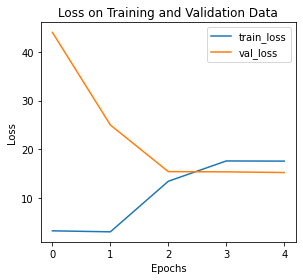

In [29]:
training_vis(train_losses, valid_losses)

#### 模型评估

在测试集上评估模型效果。

In [31]:
# 加载得分最高的模型
checkpoint = torch.load('../input/ai-earth-model-weights/task05_model_weights.pth')
model = SAConvLSTM(input_dim, hidden_dim, d_attn, kernel_size)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [32]:
# 测试集路径
test_path = '../input/ai-earth-tests/'
# 测试集标签路径
test_label_path = '../input/ai-earth-tests-labels/'

In [33]:
import os

# 读取测试数据和测试数据的标签
files = os.listdir(test_path)
X_test = []
y_test = []
for file in files:
    X_test.append(np.load(test_path + file))
    y_test.append(np.load(test_label_path + file))

In [34]:
X_test = np.array(X_test)[:, :, :, 19: 67, :1]
y_test = np.array(y_test)
X_test.shape, y_test.shape

((103, 12, 24, 48, 1), (103, 24))

In [35]:
testset = AIEarthDataset(X_test, y_test)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
# 在测试集上评估模型效果
model.eval()
model.to(device)
preds = np.zeros((len(y_test),24))
for i, data in tqdm(enumerate(testloader)):
    data, labels = data
    data = data.to(device)
    labels = labels.to(device)
    pred = model(data, train=False)
    preds[i*batch_size:(i+1)*batch_size] = pred.detach().cpu().numpy()
s = score(y_test, preds)
print('Score: {:.3f}'.format(s))

## 总结

这一次的TOP方案没有自己构造模型，而是使用了目前时空序列预测领域比较出色的模型，另一组TOP选手“ailab”也使用了这个领域经典的模型PredRNN++，大家在其他任务中也可以多去尝试相关领域的前沿模型，关于在时空序列预测领域的一些比较典型的模型可以参考https://www.zhihu.com/column/c_1208033701705162752

## 作业

该TOP方案中以sst作为预测目标，然后折算成nino3.4指数，学有余力的同学可以尝试一下用SA-ConvLSTM模型直接预测nino3.4指数。

## 参考文献

1. 吴先生的队伍方案分享：https://tianchi.aliyun.com/forum/postDetail?spm=5176.12586969.1002.9.561d5330dF9lX1&postId=231465
2. ailab团队思路分享：https://tianchi.aliyun.com/forum/postDetail?spm=5176.12586969.1002.15.561d5330dF9lX1&postId=210734